# Boosting and Stacking Exercises

## Introduction

We will be using the [Human Activity Recognition with Smartphones](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) database, which was built from the recordings of study participants performing activities of daily living (ADL) while carrying a smartphone with an embedded inertial sensors. The objective is to classify activities into one of the six activities (walking, walking upstairs, walking downstairs, sitting, standing, and laying) performed.

For each record in the dataset it is provided: 

- Triaxial acceleration from the accelerometer (total acceleration) and the estimated body acceleration. 
- Triaxial angular velocity from the gyroscope. 
- A 561-feature vector with time and frequency domain variables. 
- Its activity label. 

More information about the features is available on the website above.

In [1]:
from __future__ import print_function
import os
data_path = ['data']

## Question 1

* Import the data from the file `Human_Activity_Recognition_Using_Smartphones_Data.csv` and examine the shape and data types. For the data types, there will be too many to list each column separately. Rather, aggregate the types by count.
* Determine if the float columns need to be scaled.

In [3]:
import pandas as pd
import numpy as np

filepath = os.sep.join(data_path + ['Human_Activity_Recognition_Using_Smartphones_Data.csv'])
data = pd.read_csv(filepath, sep=',')

The data has quite a few predictor columns.

In [4]:
data.shape

(10299, 562)

And they're all float values. The only non-float is the categories column, which is what's being predicted.

In [5]:
data.dtypes.value_counts()

float64    561
object       1
dtype: int64

The minimum and maximum value for the float columns is -1.0 and 1.0, respectively. However, scaling is never required for tree-based methods.

In [6]:
# Mask to select float columns
float_columns = (data.dtypes == np.float)

# Verify that the maximum of all float columns is 1.0
print( (data.loc[:,float_columns].max()==1.0).all() )

# Verify that the minimum of all float columns is -1.0
print( (data.loc[:,float_columns].min()==-1.0).all() )

True
True


## Question 2

* Integer encode the activities.
* Split the data into train and test data sets. Decide if the data will be stratified or not during the train/test split.

In [7]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

data['Activity'] = le.fit_transform(data['Activity'])

le.classes_

array(['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS'], dtype=object)

In [9]:
le.transform(le.classes_)

array([0, 1, 2, 3, 4, 5])

In [8]:
data.Activity.unique()

array([2, 1, 0, 3, 4, 5])

**NOTE**: We are about to create training and test sets from `data`. On those datasets, we are going to run grid searches over many choices of parameters. This can take some time. In order to shorten the grid search time, feel free to downsample `data` and create `X_train, X_test, y_train, y_test` from the downsampled dataset.

Now split the data into train and test data sets. A stratified split was not used here. If there are issues with any of the error metrics on the test set, it can be a good idea to start model fitting over using a stratified split. Boosting is a pretty powerful model, though, so it may not be necessary in this case.

In [11]:
from sklearn.model_selection import train_test_split

# Alternatively, we could stratify the categories in the split, as was done previously
feature_columns = [x for x in data.columns if x != 'Activity']

X_train, X_test, y_train, y_test = train_test_split(data[feature_columns], data['Activity'],
                 test_size=0.3, random_state=42, stratify = data['Activity'])


In [12]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7209, 561), (7209,), (3090, 561), (3090,))

## Question 3

* Fit gradient boosted tree models with all parameters set to their defaults the following tree numbers (`n_estimators = [25, 50, 100, 200, 400]`) and evaluate the accuracy on the test data for each of these models. 
* Plot the accuracy as a function of estimator number.

**Note:** This question may take some time to execute, depending on how many different values are fit for estimators. Setting `max_features=4` in the gradient boosting classifier will increase the convergence rate.

Also, this is similar to question 3 from week 9, except that there is no such thing as out-of-bag error for boosted models. And the `warm_flag=True` setting has a bug in the gradient boosted model, so don't use it. Simply create the model inside the `for` loop and set the number of estimators at this time. This will make the fitting take a little longer. Additionally, boosting models tend to take longer to fit than bagged ones because the decision stumps must be fit successively.

In [17]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

error_list = list()

# Iterate through all of the possibilities for number of estimators
tree_list = [15, 50, 100, 200, 400, 800]
for n_trees in tree_list:
    
    # Initialize the gradient boost classifier
    GBC = GradientBoostingClassifier(n_estimators=n_trees, 
                                     subsample=0.5,
                                     max_features=4,
                                     random_state=42)

    # Fit the model
    GBC.fit(X_train.values, y_train.values)
    y_pred = GBC.predict(X_test)

    # Get the error
    error = 1. - accuracy_score(y_test, y_pred)
    
    # Store it
    error_list.append(pd.Series({'n_trees': n_trees, 'error': error}))

error_df = pd.concat(error_list, axis=1).T.set_index('n_trees')

error_df

,error
n_trees,
15.0,0.115534
50.0,0.043366
100.0,0.023948
200.0,0.016181
400.0,0.011650
800.0,0.008738


Now plot the result.

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [ ]:
#!pip install seaborn

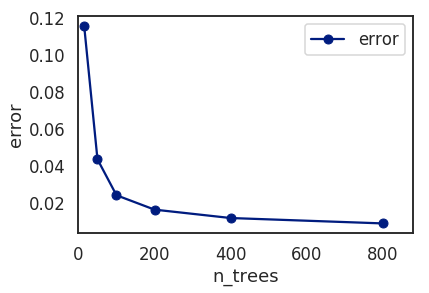

In [18]:
sns.set_context('talk')
sns.set_style('white')
sns.set_palette('dark')

# Create the plot
ax = error_df.plot(marker='o')

# Set parameters
ax.set(xlabel='n_trees', ylabel='error')
ax.set_xlim(0, max(error_df.index)*1.1);

## Question 4

* Using a grid search with cross-validation, fit a new gradient boosted classifier with the a list of estimators, similar to question 3. Also consider  varying the learning rates (0.1, 0.01, 0.001, etc.), the subsampling value (1.0 or 0.5), and the number of maximum features (1, 2, etc.).
* Examine the parameters of the best fit model.
* Calculate relevant error metrics on this model and examine the confusion matrix.

**Note:** this question may take some time to execute, depending on how many features are associated with the grid search. It is recommended to start with only a few to ensure everything is working correctly and then add more features. Setting `max_features=4` in the gradient boosting classifier will increase the convergence rate.

In [23]:
from sklearn.model_selection import GridSearchCV

# The parameters to be fit--only n_estimators and learning rate
# have been varied here for simplicity
param_grid = {'n_estimators': [200, 400, 800],
              'learning_rate': [1, 0.1, 0.01],
              'subsample': [0.1, 0.5, 1]
             }

# The grid search object
GV_GBC = GridSearchCV(GradientBoostingClassifier(max_features=4,
                                                 random_state=42), 
                      param_grid=param_grid, 
                      scoring='accuracy',
                      n_jobs=-1,
                      cv=5,
                     return_train_score=True)

# Do the grid search
GV_GBC = GV_GBC.fit(X_train, y_train)

In [24]:
pd.DataFrame(GV_GBC.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_n_estimators,param_subsample,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,6.680025,0.127109,0.148908,0.026413,1,200,0.1,"{'learning_rate': 1, 'n_estimators': 200, 'sub...",0.220222,0.138003,...,0.238175,0.090272,25,0.220989,0.137853,0.283336,0.155193,0.392721,0.238019,0.092919
1,8.784406,0.312568,0.132490,0.005545,1,200,0.5,"{'learning_rate': 1, 'n_estimators': 200, 'sub...",0.268006,0.042302,...,0.251769,0.108515,22,0.261578,0.033119,0.275533,0.301196,0.376256,0.249537,0.115225
2,7.126194,0.813941,0.047791,0.004831,1,200,1,"{'learning_rate': 1, 'n_estimators': 200, 'sub...",0.973684,0.972954,...,0.969621,0.003715,12,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
3,17.488237,0.900984,0.320653,0.039907,1,400,0.1,"{'learning_rate': 1, 'n_estimators': 400, 'sub...",0.220222,0.138003,...,0.238175,0.090272,25,0.220989,0.137853,0.283336,0.155193,0.392721,0.238019,0.092919
4,23.079675,2.653552,0.333500,0.063561,1,400,0.5,"{'learning_rate': 1, 'n_estimators': 400, 'sub...",0.268006,0.042302,...,0.251769,0.108515,22,0.261578,0.033119,0.275533,0.301196,0.376256,0.249537,0.115225
5,22.571741,3.775073,0.079692,0.024212,1,400,1,"{'learning_rate': 1, 'n_estimators': 400, 'sub...",0.973684,0.972954,...,0.969621,0.003715,12,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
6,58.632815,10.507915,0.975384,0.298245,1,800,0.1,"{'learning_rate': 1, 'n_estimators': 800, 'sub...",0.220222,0.138003,...,0.238175,0.090272,25,0.220989,0.137853,0.283336,0.155193,0.392721,0.238019,0.092919
7,52.755048,10.310031,0.829626,0.217326,1,800,0.5,"{'learning_rate': 1, 'n_estimators': 800, 'sub...",0.268006,0.042302,...,0.251769,0.108515,22,0.261578,0.033119,0.275533,0.301196,0.376256,0.249537,0.115225
8,41.499863,1.783638,0.121180,0.030282,1,800,1,"{'learning_rate': 1, 'n_estimators': 800, 'sub...",0.973684,0.972954,...,0.969621,0.003715,12,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
9,14.069415,1.075234,0.209432,0.022982,0.1,200,0.1,"{'learning_rate': 0.1, 'n_estimators': 200, 's...",0.980609,0.966713,...,0.971841,0.005157,10,0.998092,0.997226,0.996532,0.997919,0.997054,0.997364,0.000574


In [21]:
# The best model
GV_GBC.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=4, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=400,
              n_iter_no_change=None, presort='auto', random_state=42,
              subsample=0.5, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

The error metrics. Classification report is particularly convenient for multi-class cases.

In [ ]:
from sklearn.metrics import classification_report

y_pred = GV_GBC.predict(X_test)
print(classification_report(y_pred, y_test))

The confusion matrix. Note that the gradient boosted model has a little trouble distinguishing between activity class 1 and 2.

In [ ]:
from sklearn.metrics import confusion_matrix

sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d')

## Question 5

* Create an AdaBoost model and fit it using grid search, much like question 4. Try a range of estimators between 100 and 200.
* Compare the errors from AdaBoost to those from the GradientBoostedClassifier.

**NOTE:** Setting `max_features=4` in the decision tree classifier used as the base classifier for AdaBoost will increase the convergence rate.

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ABC = AdaBoostClassifier(DecisionTreeClassifier(max_features=4))

param_grid = {'n_estimators': [100, 150, 200],
              'learning_rate': [0.01, 0.001]}

GV_ABC = GridSearchCV(ABC,
                      param_grid=param_grid, 
                      scoring='accuracy',
                      n_jobs=-1)

GV_ABC = GV_ABC.fit(X_train, y_train)

The best model.

In [ ]:
# The best model
GV_ABC.best_estimator_

The error metrics. Note that the issues with class 1 and 2 appear to have become more problematic and now include class 0. Also note other issues for classes 3 - 5. AdaBoost is very sensitive to outliers, so that could be the problem here.

In [ ]:
y_pred = GV_ABC.predict(X_test)
print(classification_report(y_pred, y_test))

In [ ]:
sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d')

## Question 6

* Fit a logistic regression model with regularization. This can be a replica of a model that worked well in the exercises from week 4.
* Using `VotingClassifier`, fit the logistic regression model along with either the GratientBoostedClassifier or the AdaBoost model (or both) from questions 4 and 5.
* Determine the error as before and compare the results to the appropriate gradient boosted model(s).
* Plot the confusion matrix for the best model created in this set of exercises.

In [ ]:
from sklearn.linear_model import LogisticRegressionCV

# L2 regularized logistic regression
LR_L2 = LogisticRegressionCV(Cs=5, cv=4, penalty='l2').fit(X_train, y_train)

Check the errors and confusion matrix for the logistic regression model.

In [ ]:
y_pred = LR_L2.predict(X_test)
print(classification_report(y_pred, y_test))

In [ ]:
sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d')

And now the stacked model.

In [ ]:
from sklearn.ensemble import VotingClassifier

# The combined model--logistic regression and gradient boosted trees
estimators = [('LR_L2', LR_L2), ('GBC', GV_GBC)]

# Though it wasn't done here, it is often desirable to train 
# this model using an additional hold-out data set and/or with cross validation
VC = VotingClassifier(estimators, voting='soft')
VC = VC.fit(X_train, y_train)

Finally the error on the voting classifier. We do a little better here than with either logistic regression or gradient boosted trees alone. However, the fact that logistic regression does almost as well as gradient boosted trees is an important reminder that it's good practice to try the simplest model first. In some cases, its performance will be good enough.

In [ ]:
y_pred = VC.predict(X_test)
print(classification_report(y_test, y_pred))

In [ ]:
sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d')

## Question 7
* Import the iris data and examine the features.
* We will be using all of them to predict species, but the species feature will need to be integer encoded.
* Download iris.csv from https://www.kaggle.com/uciml/iris/data/  and rename it as Iris_Data.csv

Convert the species feature to an integer. This is a quick way to do it using Pandas.

## Question 8

* Use `StratifiedShuffleSplit` to split data into train and test sets that are stratified by species. If possible, preserve the indices of the split for question 11 below.
* Check the percent composition of each species level for both the train and test data sets.

In [ ]:
# All data columns except for species


Now check the percent composition of target class in the train and test iris_data sets.

## Question 9

* Fit gradient boosted tree models with all parameters set to their defaults the following tree numbers (`n_estimators = [25, 50, 100, 200, 400]`) and evaluate the accuracy on the test data for each of these models. 
* Plot the accuracy as a function of estimator number.

**Note:** This question may take some time to execute, depending on how many different values are fit for estimators. Setting `max_features=4` in the gradient boosting classifier will increase the convergence rate.

Also, this is similar to question 9 from week 9, except that there is no such thing as out-of-bag error for boosted models. And the `warm_flag=True` setting has a bug in the gradient boosted model, so don't use it. Simply create the model inside the `for` loop and set the number of estimators at this time. This will make the fitting take a little longer. Additionally, boosting models tend to take longer to fit than bagged ones because the decision stumps must be fit successively.

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score



Now plot the result.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

% matplotlib inline

## Question 10

* Using a grid search with cross-validation, fit a new gradient boosted classifier with the a list of estimators, similar to question 9. Also consider  varying the learning rates (0.1, 0.01, 0.001, etc.), the subsampling value (1.0 or 0.5), and the number of maximum features (1, 2, etc.).
* Examine the parameters of the best fit model.
* Calculate relevant error metrics on this model and examine the confusion matrix.

**Note:** this question may take some time to execute, depending on how many features are associated with the grid search. It is recommended to start with only a few to ensure everything is working correctly and then add more features. Setting `max_features=4` in the gradient boosting classifier will increase the convergence rate.

In [ ]:
from sklearn.model_selection import GridSearchCV



In [ ]:
# The best model


The error metrics. Classification report is particularly convenient for multi-class cases.

In [ ]:
from sklearn.metrics import classification_report



The confusion matrix. Note that the gradient boosted model has a little trouble distinguishing between species  class 0,1 and 2.

In [ ]:
from sklearn.metrics import confusion_matrix


## Question 11

* Create an AdaBoost model and fit it using grid search, much like question 10. Try a range of estimators between 100 and 200.
* Compare the errors from AdaBoost to those from the GradientBoostedClassifier.

**NOTE:** Setting `max_features=4` in the decision tree classifier used as the base classifier for AdaBoost will increase the convergence rate.

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier



The best model.

In [ ]:
# The best model


The error metrics. Note that the issues with class 0,1 and 2 appear to have become more problematic and now include class 0. AdaBoost is very sensitive to outliers, so that could be the problem here.

## Question 12

* Fit a logistic regression model with regularization. This can be a replica of a model that worked well in the exercises from week 4.
* Using `VotingClassifier`, fit the logistic regression model along with either the GratientBoostedClassifier or the AdaBoost model (or both) from questions 10 and 11.
* Determine the error as before and compare the results to the appropriate gradient boosted model(s).
* Plot the confusion matrix for the best model created in this set of exercises.

In [ ]:
from sklearn.linear_model import LogisticRegressionCV

# L2 regularized logistic regression


Check the errors and confusion matrix for the logistic regression model.

And now the stacked model.

In [ ]:
from sklearn.ensemble import VotingClassifier



Finally the error on the voting classifier. We do a little better here than with either logistic regression or gradient boosted trees alone. However, the fact that logistic regression does almost as well as gradient boosted trees is an important reminder that it's good practice to try the simplest model first. In some cases, its performance will be good enough.